In [1]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


# Implementar o batch gradient descent

In [2]:
%matplotlib inline

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import torch
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd

In [3]:
iris = load_iris()
print(type(iris))
print('iris.data:',iris.data.shape,iris.data.dtype,iris.data.min(),iris.data.max())
print('iris.target:',iris.target.shape,iris.target.dtype,iris.target.min(),iris.target.max())
#print(iris.DESCR)
print('iris.features_name:',iris.feature_names)
print('iris.target_names:',iris.target_names)

iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd['target'] = iris.target
iris_pd


<class 'sklearn.datasets.base.Bunch'>
iris.data: (150, 4) float64 0.1 7.9
iris.target: (150,) int64 0 2
iris.features_name: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris.target_names: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [4]:
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x = data[:,0:1]
y = data[:,1:2]

print('x.shape:',x.shape, x.dtype)
print('y.shape:',y.shape, y.dtype)

print('x[:5]:\n', x[:5])
print('y[:5]:\n', y[:5])

x.shape: (50, 1) float64
y.shape: (50, 1) float64
x[:5]:
 [[ 7. ]
 [ 6.4]
 [ 6.9]
 [ 5.5]
 [ 6.5]]
y[:5]:
 [[ 4.7]
 [ 4.5]
 [ 4.9]
 [ 4. ]
 [ 4.6]]


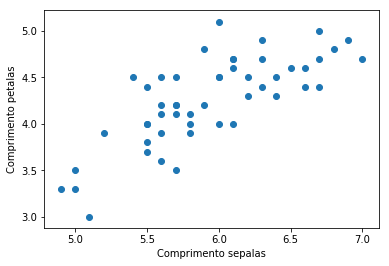

In [5]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

In [6]:
x -= x.min()
x /= x.max()    # normalização
y -= y.min()
y /= y.max()


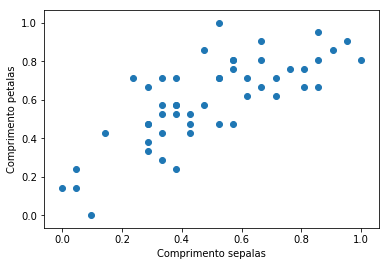

In [7]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

In [9]:
def compute_cost(X_b, y, wT):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n_samples,2) e y(n_samples,)
    wT: vetor coluna de parâmetros (já transposto)
       aceita tanto shape (2,1) Para um caso como (2,n_history) para n_history casos
    '''
    e = X_b.dot(wT) - y
    J = (e * e).mean(axis=0)
    return J

In [27]:
def tensors(X,dtype,grad):
        
    X = Variable(torch.from_numpy(X).type(dtype), requires_grad=grad)
    return X
def getbatches(X, Y, limit, batchsize):
   
    '''
    Input parameters:
    X,Y = Shuffled dataset as numpay matrix
    Output = several batches choosen randomly
    batchx,batchy = shape(batchsize,:)
    '''
    indeces = np.random.randint(limit, size=limit)
    for j in indeces:
        batch_x = X[j:j+batchsize,:]
        batch_y = Y[j:j+batchsize]
        batch_x_tensor = tensors(batch_x,torch.FloatTensor,False)
        batch_y_tensor = tensors(batch_y,torch.FloatTensor,False)
        
        yield batch_x_tensor, batch_y_tensor

def mini_batch_gradient_descent(X, Y, w_init, lr, n_epochs,batchsize):
    '''
    Perform mini-batch  gradient descent
    
    Parameters:
    X = samples
    Y = result
    w_init = initial guess for the weights = w_init.shape:(1,2)
    lr = learning_rate
    n_epochs = number of training epochs
    batchsize = size of the mini-batch
    
    
    Labeled data: X.shape:(M,2) e y.shape:(M,1)
    
    output: w_history:(n_epochs * (X.shape[0] - batchsize + 1))
    '''
    
    M = Y.size
    limit = M - batchsize + 1
    w_history = np.zeros((2,(limit*n_epochs)+1))
    wT = w_init.T
    w_history[:,0] = wT[:,0]
    W = tensors(wT,torch.FloatTensor,True)
    '''   
    def tensors(X,y,W,dtype):
        
        X = Variable(torch.from_numpy(X).type(dtype), requires_grad=False)
        y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
        W = Variable(torch.from_numpy(W).type(dtype), requires_grad=True)
        return X,y,W
    '''
  #  X,y,wT = tensors(X,Y,wT,torch.FloatTensor)

    for i in range(n_epochs):
        #Shuffle the indices array
        indices = np.arange(X.shape[0])
        #indices = torch.range(0,X.size()[0]-1)
        
        np.random.shuffle(indices)
        
        #Return an iterable of x and y batches
        batchs = getbatches(X[indices,:], y[indices], limit, batchsize)

        j = 0
        for  batch_x, batch_y in batchs:
            #print(batch_x.size())
            loss = (batch_x.mm(W) - batch_y).pow(2).sum()
            loss.backward()
            
            #Apply the gradient descent for each batch
            #wT = wT - lr * (2.0 / batchsize) * (batch_x.T).dot(batch_x.dot(wT) - batch_y)
            W.data -= (lr/batch_x.size()[0]) * W.grad.data
            
            #Guarantees that the w_history is being written in the right places
            w_history[:,j+(i*limit)+1] = W.data.numpy()[:,0]
            W.grad.data.zero_()
            j = j + 1
    return w_history.T

In [18]:
import time
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 100
lr = 0.1
n_samples = y.shape[0]
X_bias = np.hstack([np.ones(shape=(n_samples,1)), x])
w_init = np.zeros(shape=(1,2))
print(X_bias.shape)

(50, 2)


In [28]:
w_history_batch = mini_batch_gradient_descent(X_bias, y, w_init, lr, iterations,batchsize=50)


# Printando Mini-Batch

In [29]:
batchsize=11
w_history_mini = mini_batch_gradient_descent(X_bias, y, w_init, lr, iterations,batchsize)
print(w_history_mini.shape)
J_history_mini = compute_cost(X_bias, y, w_history_mini.T)
print(J_history_mini)

(4001, 2)
[ 0.40907029  0.26125606  0.14312671 ...,  0.0213398   0.02118315
  0.02124195]


# Printando Batch Gradient Descent


batchsize = n_samples
w_history_batch = mini_batch_gradient_descent(X_bias, y, w_init, lr, iterations,batchsize)
J_history_batch = compute_cost(X_bias, y, w_history_batch.T)
print(J_history_batch)

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

### Gerando a figura para correção automática

<a id='figura'></a>

fig = plt.figure(figsize=(20,5))
plt.suptitle('Visualizacão do erro')

ax = fig.add_subplot(131)
plt.title("Batch size 1")
#ax.plot(J_history_stochastic)
ax.plot(J_history_stochastic)

ay = fig.add_subplot(132)
plt.title("Batch size T")
#ay.plot(J_history)
ay.plot(J_history_mini)

az = fig.add_subplot(133)
plt.title("Batch size num_amostras")
#az.plot(J_history)
az.plot(J_history_batch)
plt.savefig('my_sgd_minibatch.png')

### Gerando a figura para correção automática


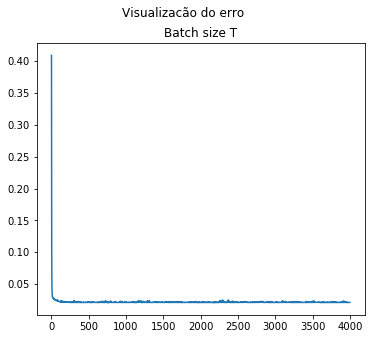

In [30]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Visualizacão do erro')

ay = fig.add_subplot(132)
plt.title("Batch size T")
#ay.plot(J_history)
ay.plot(J_history_mini)
plt.show()